In [2]:
# Taking exercise 3.3 as reference
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import matplotlib.animation as manimation
import time


@njit
def two_body_ode(position, mu):
    r = np.sqrt(position[0] ** 2 + position[1] ** 2)
    a_x = - mu * position[0] / r ** 3
    a_y = - mu * position[1] / r ** 3
    return np.array([a_x, a_y])

@njit
def rk45_step(t, pos_i, vel_i, h, epsi, h_max, h_min, mu):
    
               # Coeficients from Hairer, Norsett & Wanner 1993
 
 # Coeffients for each k
    B21 =   2.500000000000000e-01  #  1/4
    B31 =   9.375000000000000e-02  #  3/32
    B32 =   2.812500000000000e-01  #  9/32
    B41 =   8.793809740555303e-01  #  1932/2197
    B42 =  -3.277196176604461e+00  # -7200/2197
    B43 =   3.320892125625853e+00  #  7296/2197
    B51 =   2.032407407407407e+00  #  439/216
    B52 =  -8.000000000000000e+00  # -8
    B53 =   7.173489278752436e+00  #  3680/513
    B54 =  -2.058966861598441e-01  # -845/4104
    B61 =  -2.962962962962963e-01  # -8/27
    B62 =   2.000000000000000e+00  #  2
    B63 =  -1.381676413255361e+00  # -3544/2565
    B64 =   4.529727095516569e-01  #  1859/4104
    B65 =  -2.750000000000000e-01  # -11/40

# Coefficients for the Truncation error (of the taylor expansion)
    CT1  =   2.777777777777778e-03  #  1/360
    CT2  =   0.000000000000000e+00  #  0
    CT3  =  -2.994152046783626e-02  # -128/4275
    CT4  =  -2.919989367357789e-02  # -2197/75240
    CT5  =   2.000000000000000e-02  #  1/50
    CT6  =   3.636363636363636e-02  #  2/55

# Coefficients for the weighted average (4th order)
# 4th order is used as it is the order to which the error is calculated
    CH1  =   1.157407407407407e-01  #  25/216
    CH2  =   0.000000000000000e+00  #  0
    CH3  =   5.489278752436647e-01  #  1408/2565
    CH4  =   5.353313840155945e-01  #  2197/4104
    CH5  =  -2.000000000000000e-01  # -1/5
    CH6  =   0.000000000000000e+00  #  0

    
    TE_step = epsi + 1
    while TE_step > epsi:
        if h > h_max:
            h = h_max
            
        elif h < h_min:
            h = h_min

        k1 = two_body_ode(pos_i, mu)

        pos_k2 = pos_i + vel_i * B21 * h
        k2 = two_body_ode(pos_k2, mu)
        vel_k2 = vel_i + k1 * B21 * h

        pos_k3 = pos_i + vel_i * B31 * h + vel_k2 * B32 * h
        k3 = two_body_ode(pos_k3, mu)
        vel_k3 = vel_i + k1 * B31 * h + k2 * B32 * h    

        pos_k4 = pos_i + vel_i * B41 * h + vel_k2 * B42 * h + vel_k3 * B43 * h
        k4 = two_body_ode(pos_k4, mu)
        vel_k4 = vel_i + k1 * B41 * h + k2 * B42 * h + k3 * B43 * h

        pos_k5 = pos_i + vel_i * B51 * h + vel_k2 * B52 * h + vel_k3 * B53 * h + vel_k4 * B54 * h
        k5 = two_body_ode(pos_k5, mu)
        vel_k5 = vel_i + k1 * B51 * h + k2 * B52 * h + k3 * B53 * h + k4 * B54 * h

        pos_k6 = pos_i + vel_i * B61 * h + vel_k2 * B62 * h + vel_k3 * B63 * h + vel_k4 * B64 * h + vel_k5 * B65 * h
        k6 = two_body_ode(pos_k6, mu)
        vel_k6 = vel_i + k1 * B61 * h + k2 * B62 * h + k3 * B63 * h + k4 * B64 * h + k5 * B65 * h

        a = CH1 * k1 + CH2 * k2 + CH3 * k3 + CH4 * k4 + CH5 * k5 + CH6 * k6
        
        TE_step = np.abs(CT1 * k1 + CT2 * k2 + CT3 * k3 + CT4 * k4 + CT5 * k5 + CT6 * k6)
        TE_step = np.max(TE_step)  # Error is always the maximum error
        if TE_step == 0:
            t = t + h
            return TE_step, t, a, h          
        if h >= h_max or h <= h_min:
            t = t + h
            return TE_step, t, a, h       
        h = 0.9 * h * (epsi / TE_step) ** (1/5)
        h = np.min(np.array(h))        
        if h > h_max:
            h = h_max 
        elif h < h_min:
            h = h_min
        else:
            t = t + h
            return TE_step, t, a, h # just to break the loop        
    t = t + h
    return TE_step, t, a, h


def main(pos_i, vel_i, t, t_f, h, epsilon, h_maximum, h_minimum, mu, name_comet = 'comet'):
    
    pos_x = []
    pos_y = []
    h_array = []
    speed_array = []
    error_array = []
    time_array = []
    while t < t_f:
        error, t, a_, h = rk45_step(t, pos_i, vel_i, h, epsilon, h_maximum, h_minimum, mu)
        vel_i = vel_i + a_ * h
        pos_i = pos_i + vel_i * h
        #print(h)
        error_array = np.append(error_array, error)
        pos_x = np.append(pos_x, pos_i[0])
        pos_y = np.append(pos_y, pos_i[1])
        speed = np.sqrt(vel_i[1] ** 2 + vel_i[1] ** 2)
        speed_array = np.append(speed_array, speed)
        time_array = np.append(time_array, t)
        h_array.append(h)
    print(len(pos_x))
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(np.sqrt(pos_x ** 2 + pos_y ** 2), h_array, '.', markersize = 3 , markerfacecolor = 'black')
    plt.title('Evolution of step size in relation to distance to sun')
    plt.xlabel('Distance to sun (AU)')
    plt.ylabel('Step size (h)')
    plt.grid(True)
    plt.show()
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(time_array, h_array, '.', markersize = 3 , markerfacecolor = 'black')
    plt.title('Evolution of step size in relation to time')
    plt.xlabel('Time (Years)')
    plt.ylabel('Step size (h)')
    plt.grid(True)
    plt.show()
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(time_array, speed_array, '.', markersize = 3 , markerfacecolor = 'black')
    plt.title('Evolution of speed')
    plt.ylabel('Speed in AU / Year')
    plt.xlabel('Time (Years)')
    plt.grid(True)
    plt.show()
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(time_array, error_array, '.', markersize = 3 , markerfacecolor = 'black')
    plt.title('Evolution of error')
    plt.xlabel('Time (Years)')
    plt.ylabel('Error')
    plt.grid(True)
    plt.show()
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(pos_x, pos_y,'.', markersize = 1 , markerfacecolor = 'purple')
    plt.plot(0,0,'.', markersize =3 , markerfacecolor = 'black')
    plt.annotate('SUN', xy =(0 ,0) , ha='center', va='center', bbox = dict ( boxstyle =" circle ", fc ="darkorange") )
    plt.title('Plot of %s orbit in Au' %name_comet)
    plt.xlabel('x (AU)')
    plt.ylabel('y (AU)')
    plt.grid(True)
    plt.axis('scaled')
    plt.show()
    print(np.min(pos_x))
    

## Halley Comet

Halley was only 0.5871 AU (87.8 million km: 54.6 million miles) from the Sun, well inside the orbit of Venus. Halley was moving at 122,000 mph (54.55 kilometers per second)

Orbital period (sidereal)	74.7 yr
75y 5m 19d (perihelion to perihelion)

In [3]:
# Units: AU and years
v_halley = 122000 / 10611.393524 # miles/h to AU/year
print(v_halley, ':  AU per Year')
px_halley =  0.5871
# G*M for the sun
GM = 1.32712440042e20  #m3s-2
GM *= 31_556_952 ** 2  # second to year squared
GM /= 149597870691 ** 3 
print(GM, ':  AU ** 3 * y ** -2')

11.497076206256057 :  AU per Year
39.47530521614961 :  AU ** 3 * y ** -2


In [ ]:
pos_initial = np.array([px_halley, 0])
vel_initial = np.array([0,v_halley])
t_ = 0
t_final = 70
epsilon_ = 2e-15
h_maximum_ = 10
h_minimum_ = 5e-10
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds processing time")

21061


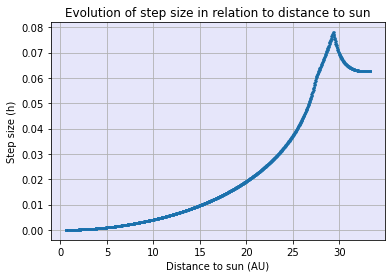

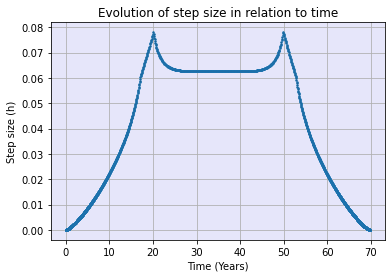

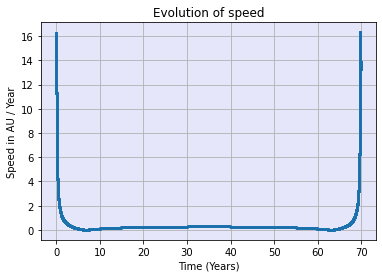

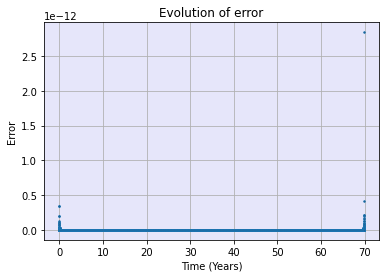

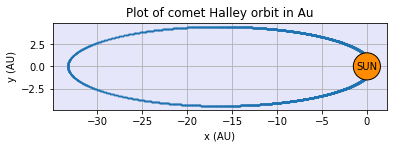

-33.30303030348673
1.1613948345184326 seconds process time


In [66]:
pos_initial = np.array([px_halley, 0])
vel_initial = np.array([0,v_halley])
t_ = 0
t_final = 69.8
epsilon_ = 5e-15
h_maximum_ = 10
h_minimum_ = 1e-7
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

28093


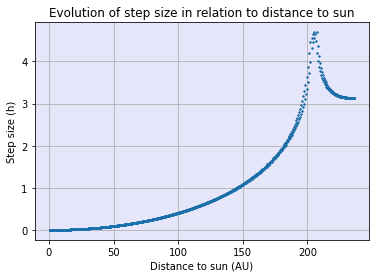

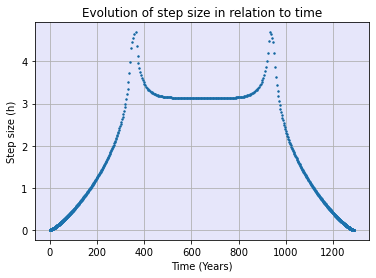

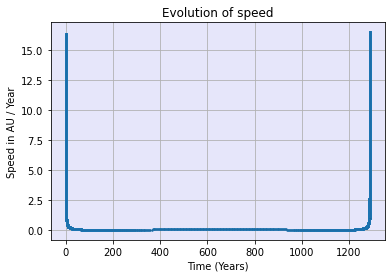

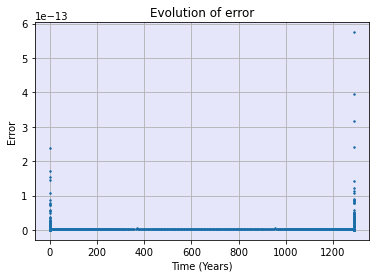

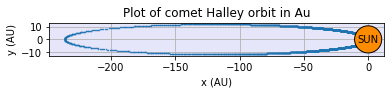

-236.14831425719925
1.4985103607177734 seconds process time


In [68]:
pos_initial = np.array([px_halley * 1.005, 0])
vel_initial = np.array([0, v_halley * 1.005])
t_ = 0
t_final = 1290
epsilon_ = 5e-15
h_maximum_ = 100
h_minimum_ = 1e-7
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

2117


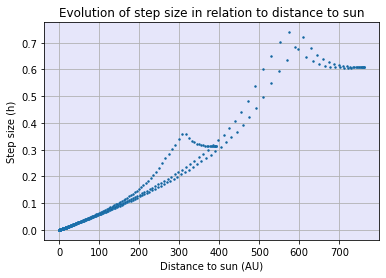

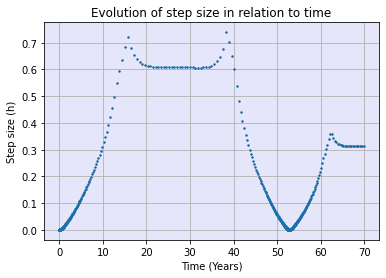

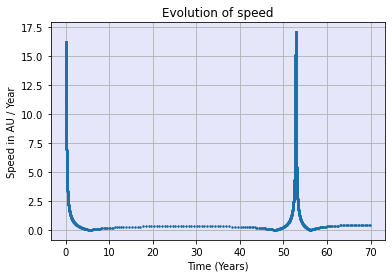

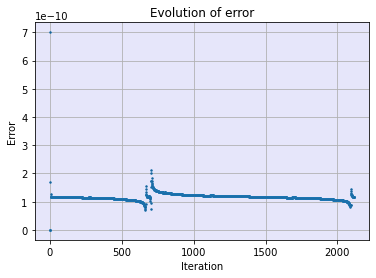

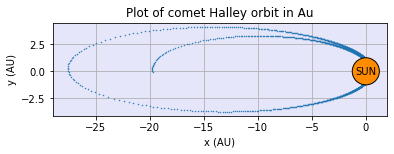

0.5104033946990967 seconds process time


In [26]:
pos_initial = np.array([px_halley, 0])
vel_initial = np.array([0,v_halley])
t_ = 0
t_final = 69.8
epsilon_ = 2e-10
h_maximum_ = 10
h_minimum_ = 1e-8
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

131744


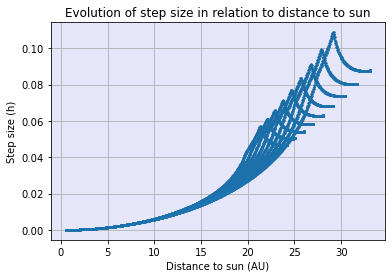

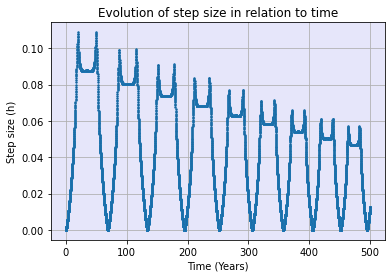

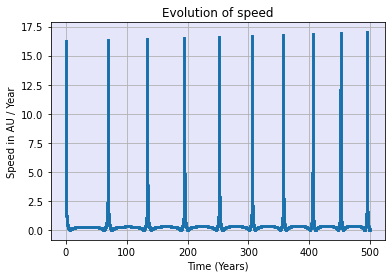

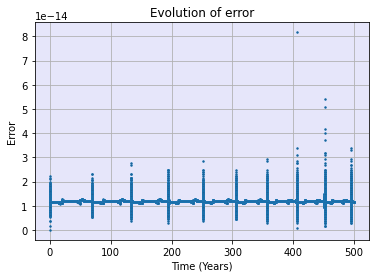

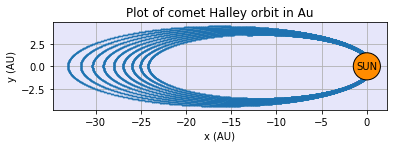

-33.09723397868688
21.14301824569702 seconds process time


In [64]:
pos_initial = np.array([px_halley, 0])
vel_initial = np.array([0,v_halley])
t_ = 0
t_final = 500
epsilon_ = 2e-14
h_maximum_ = 10
h_minimum_ = 1e-7
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

366717


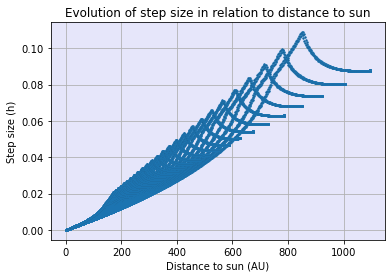

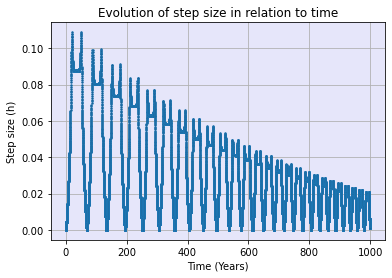

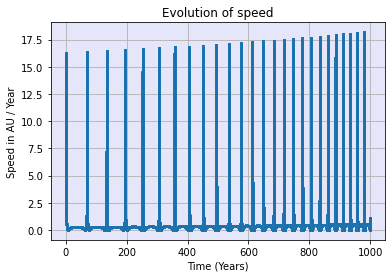

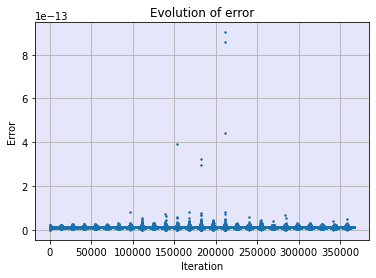

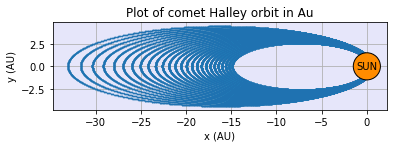

537.7314183712006 seconds process time


In [16]:
pos_initial = np.array([px_halley, 0])
vel_initial = np.array([0,v_halley])
t_ = 0
t_final = 1000
epsilon_ = 2e-14
h_maximum_ = 10
h_minimum_ = 1e-7
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

In [ ]:
pos_initial = np.array([px_halley, 0])
vel_initial = np.array([0,v_halley])
t_ = 0
t_final = 70
epsilon_ = 1e-15
h_maximum_ = 10
h_minimum_ = 1e-25
h_ = 1e-10
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

At aphelion in 1948, Halley was 35.25 AU (3.28 billion miles or 5.27 billion kilometers) from the Sun, well beyond the distance of Neptune. The comet was moving 0.91 kilometers per second (2,000 mph).

In [69]:
# Units: AU and years
v_halley2 = 2035.612 / 10611.393524 # miles/h to AU/year
print(v_halley2, ':  AU per Year')
px_halley2 =  35.25
# G*M for the sun
GM = 1.32712440042e20  #m3s-2
GM *= 31_556_952 ** 2  # second to year squared
GM /= 149597870691 ** 3 
print(GM, ':  AU ** 3 * y ** -2')

0.19183267451122382 :  AU per Year
39.47530521614961 :  AU ** 3 * y ** -2


13648


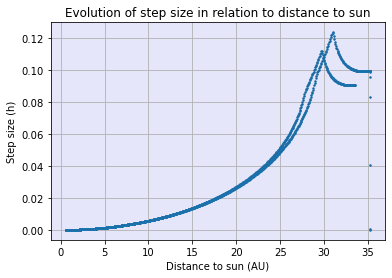

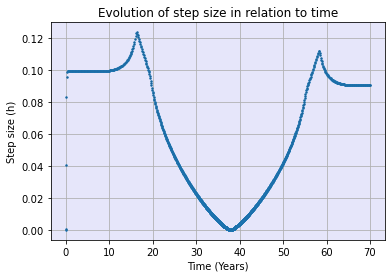

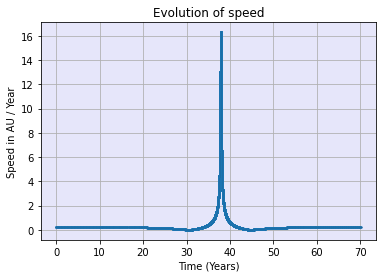

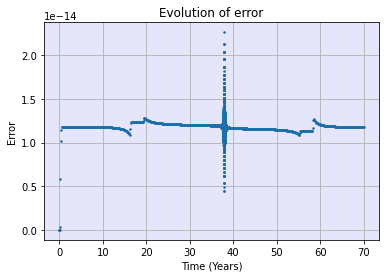

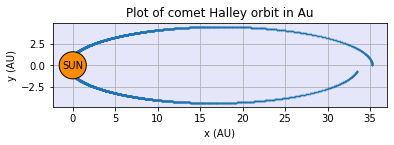

-0.5853738498659607
0.9814493656158447 seconds process time


In [70]:
pos_initial = np.array([px_halley2, 0])
vel_initial = np.array([0,v_halley2])
t_ = 0
t_final = 70
epsilon_ = 2e-14
h_maximum_ = 10
h_minimum_ = 1e-8
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

5264


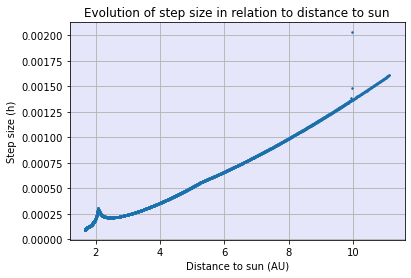

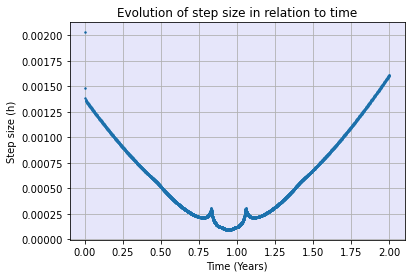

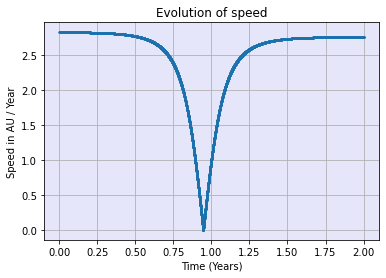

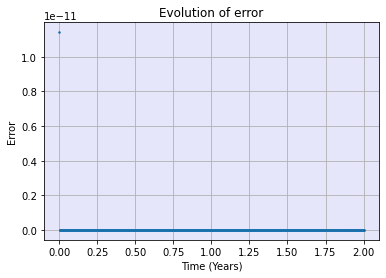

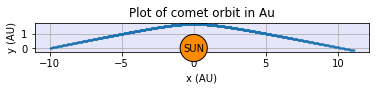

-9.97968713536337
2.704371690750122 seconds process time


In [71]:
G_M = 39.5 
pos_initial = np.array([-10, 0])
vel_initial = np.array([10, 2])
t_ = 0
t_final = 2
h_ = 0.01
epsilon_ = 6.685e-15
h_maximum_ = 0.11
h_minimum_ = 1e-15
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, G_M)
print(time.time() - t0_proc, "seconds process time")

36593


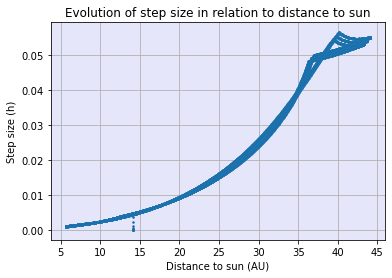

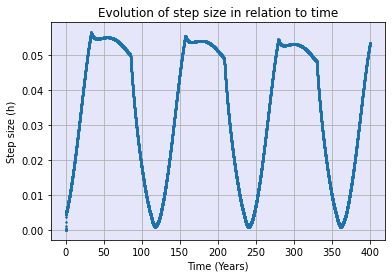

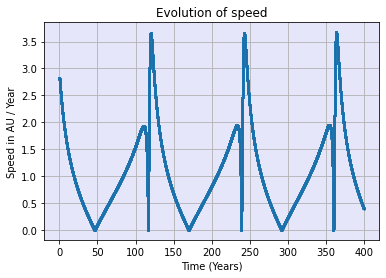

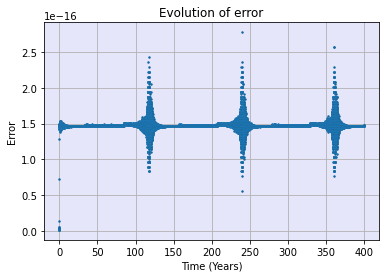

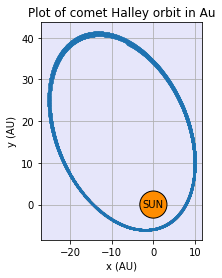

-25.206515795313344
2.590264320373535 seconds process time


In [91]:
pos_initial = np.array([10, 10])
vel_initial = np.array([0, 2])
t_ = 0
t_final = 400
epsilon_ = 2.5e-16
h_maximum_ = 10
h_minimum_ = 1e-7
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")